In [1]:
##Sect 413 Midterm Project
#DRobb

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import os
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

# plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
    
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

    
# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

In [4]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [5]:
#Bring in the Data

train = pd.read_csv('train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'], index_col=['date'])
train.index = pd.to_datetime(train.index)
train.shape, test.shape


((913000, 3), (45000, 3))

In [6]:
train.shape, test.shape

((913000, 3), (45000, 3))

In [7]:
train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [64]:
train.tail()

,store,item,sales,Day
date,,,,
2017-12-27,10,50,4.158883,Wednesday
2017-12-28,10,50,4.094345,Thursday
2017-12-29,10,50,4.317488,Friday
2017-12-30,10,50,4.143135,Saturday
2017-12-31,10,50,4.418841,Sunday


In [8]:
test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [47]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,3.820443
std,2.872283,14.430878,0.578715
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,3.433987
50%,5.500000,25.500000,3.871201
75%,8.000000,38.000000,4.262680
max,10.000000,50.000000,5.446737


In [62]:
sel_col = ['item', 'store']
test[sel_col].describe()

,item,store
count,45000.00000,45000.000000
mean,25.50000,5.500000
std,14.43103,2.872313
min,1.00000,1.000000
25%,13.00000,3.000000
50%,25.50000,5.500000
75%,38.00000,8.000000
max,50.00000,10.000000


## Exploratory Analysis

### Store Trends

In [9]:
stores = pd.DataFrame(train.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

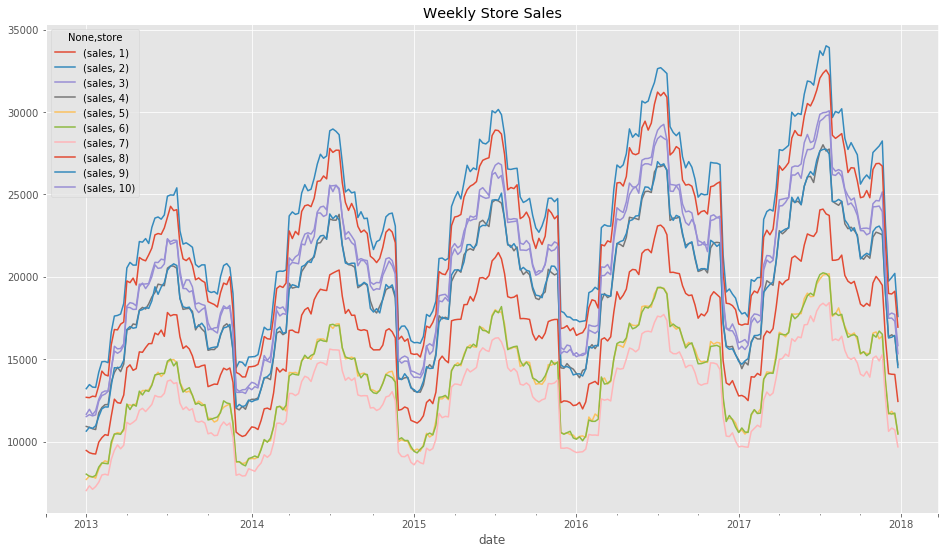

In [10]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=True)
plt.show()

In [11]:
stores.head(10)

sales                                                         \
store          1      2      3      4      5      6     7      8      9    
date                                                                       
2013-01-01   9461  13209  11658  10918   7704   8025  7028  12684  10633   
2013-01-08   9325  13459  11959  10859   7898   7897  7316  12663  10869   
2013-01-15   9266  13306  11633  10778   7865   7851  7104  12754  10798   
2013-01-22   9247  13286  11871  10729   7782   7950  7271  12726  10957   
2013-01-29   9967  14210  12567  11743   8333   8453  7536  13402  11518   
2013-02-05  10236  14844  12973  12068   8678   8705  7972  14275  11987   
2013-02-12  10421  14861  13068  12239   8835   8676  8020  14055  12104   
2013-02-19  10373  14788  13068  12249   8740   8654  7965  13983  12095   
2013-02-26  11539  16636  14359  13603   9793   9970  8916  15869  13383   
2013-03-05  12573  17616  15784  14190  10453  10456  9473  16798  14483   

                   
store          10  
date               
2013-01-01  11516  
2013-01-08  11634  
2013-01-15  11558  
2013-01-22  11618  
2013-01-29  12448  
2013-02-05  12791  
2013-02-12  12879  
2013-02-19  13051  
2013-02-26  14400  
2013-03-05  15492

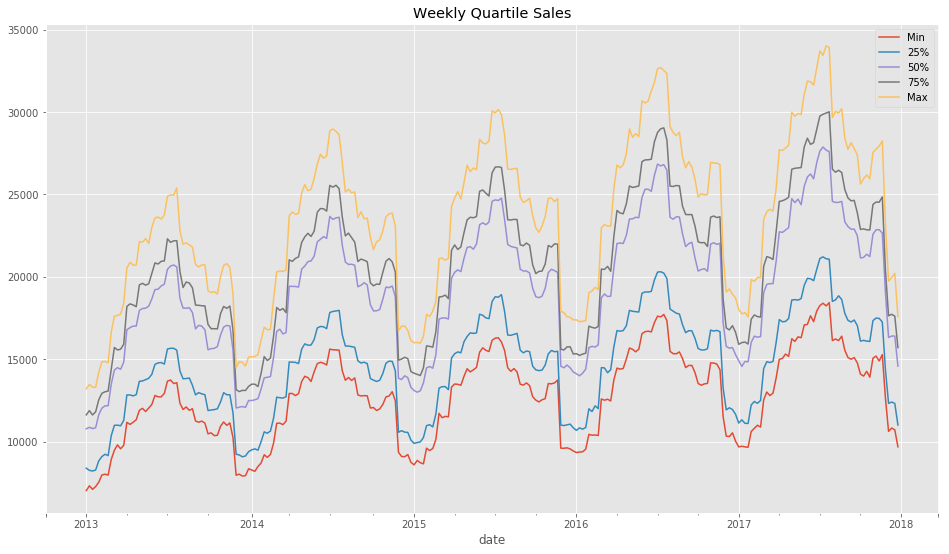

In [14]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

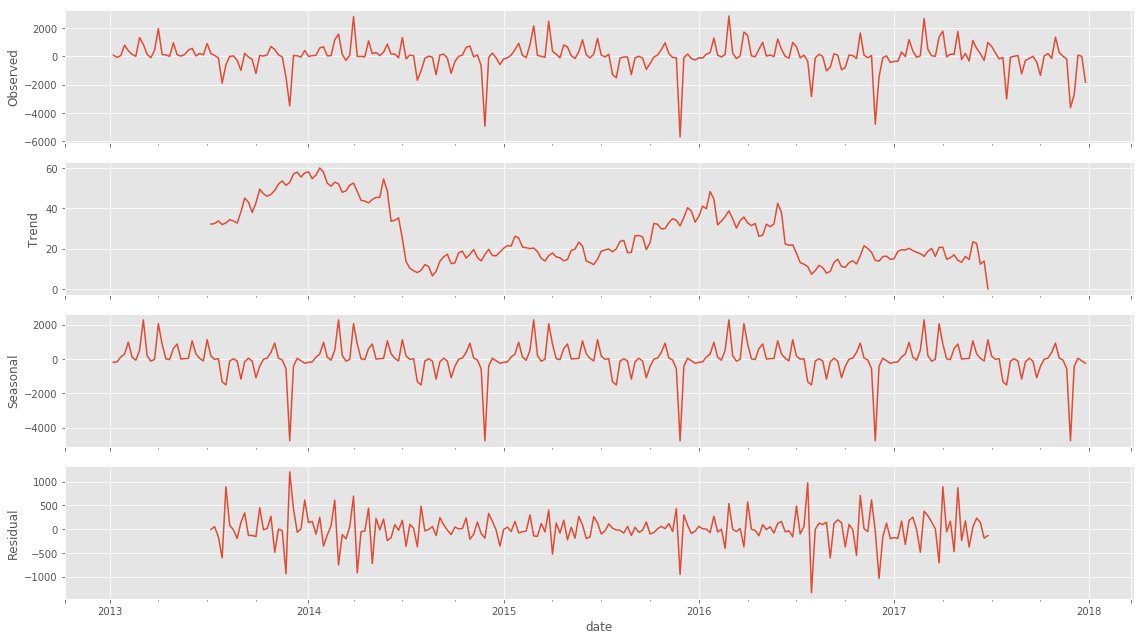

In [15]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [16]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Item Trends

In [17]:
items = pd.DataFrame(train.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                                                        ...   \
item          1     2     3     4     5     6     7     8     9     10  ...    
date                                                                    ...    
2017-10-03  1769  4471  2740  1677  1372  4515  4503  5842  3917  5573  ...    
2017-10-10  1758  4454  2858  1757  1392  4483  4510  5932  3861  5771  ...    
2017-10-17  1732  4481  2856  1700  1396  4470  4606  6016  3911  5752  ...    
2017-10-24  1662  4422  2767  1724  1456  4476  4478  6083  3873  5654  ...    
2017-10-31  1774  4798  3087  1680  1476  4766  4837  6415  4276  6088  ...    
2017-11-07  1735  4887  3143  1879  1540  4686  4867  6403  4335  6161  ...    
2017-11-14  1824  4812  3094  1816  1479  4882  4854  6439  4251  5965  ...    
2017-11-21  1818  4840  3076  1876  1576  4835  4936  6427  4181  6053  ...    
2017-11-28  1490  4042  2527  1509  1301  4137  3932  5415  3548  5108  ...    
2017-12-05  1311  3551  2182  1296  1179  3562  3522  4510  3018  4358  ...    
2017-12-12  1308  3498  2251  1277  1125  3541  3381  4699  3014  4372  ...    
2017-12-19  1262  3450  2181  1306  1085  3463  3477  4516  2971  4428  ...    
2017-12-26  1167  3180  1956  1150  1000  2973  3170  4065  2764  3722  ...    

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2017-10-03  1629  2845  3963  2416  6089  4620  1696  3973  2285  5054  
2017-10-10  1741  2815  3892  2338  6213  4529  1644  3949  2208  4967  
2017-10-17  1619  2778  4005  2245  6198  4560  1700  3949  2260  5070  
2017-10-24  1644  2761  3927  2346  6404  4494  1739  4021  2202  5074  
2017-10-31  1817  3038  4318  2386  6623  4889  1798  4257  2468  5323  
2017-11-07  1764  3067  4358  2408  6711  4947  1820  4291  2417  5542  
2017-11-14  1807  3076  4315  2424  6774  4884  1755  4318  2475  5349  
2017-11-21  1872  2987  4273  2392  6530  4915  1860  4329  2364  5517  
2017-11-28  1610  2635  3529  2051  5524  4028  1591  3580  1991  4503  
2017-12-05  1280  2148  2985  1756  4695  3510  1283  3101  1669  3829  
2017-12-12  1349  2213  3100  1785  4721  3483  1279  3051  1701  3856  
2017-12-19  1240  2115  3162  1669  4772  3524  1361  3177  1689  3900  
2017-12-26  1124  1893  2680  1546  4349  3182  1166  2655  1546  3411  

[13 rows x 50 columns]

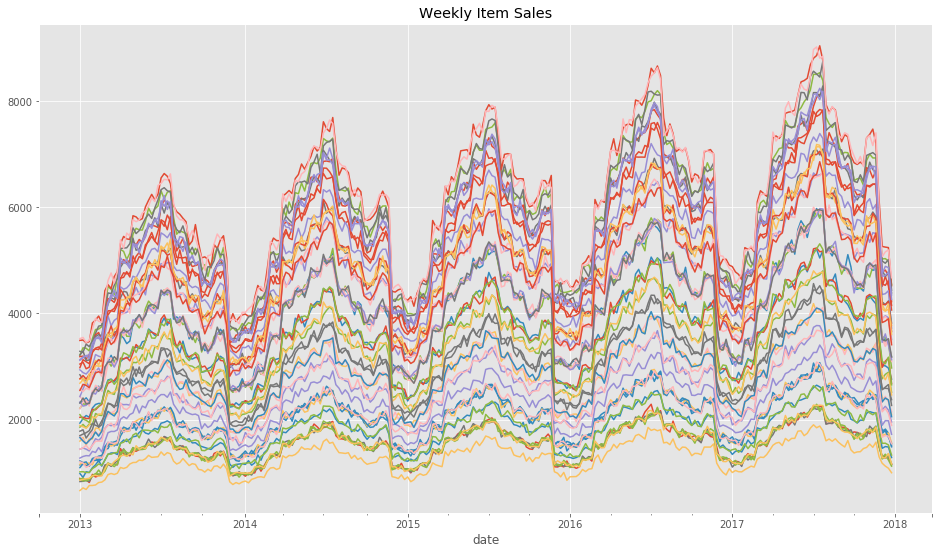

In [19]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

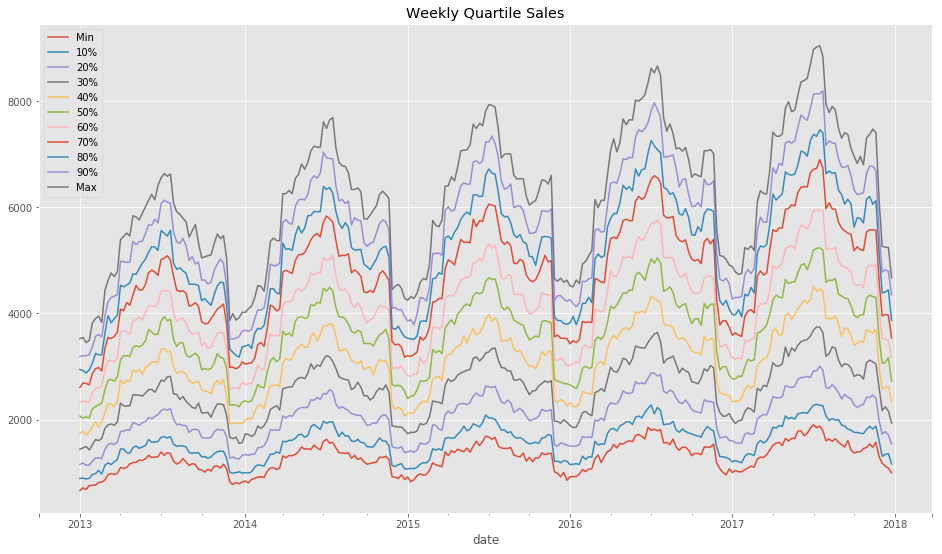

In [20]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

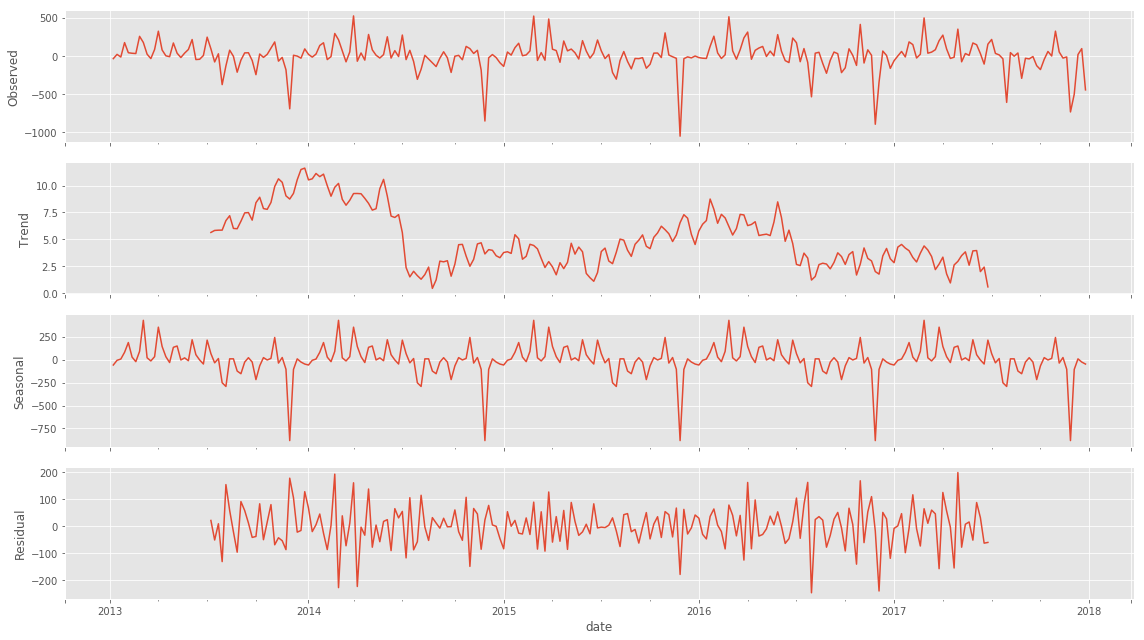

In [21]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()

In [22]:
Fuller(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -13.061788
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Store & Item Trends

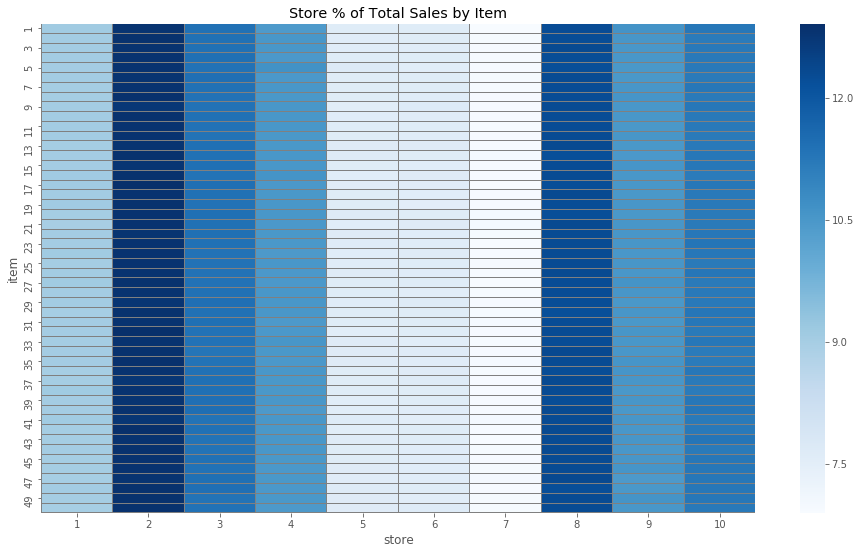

In [23]:
store_item = train.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

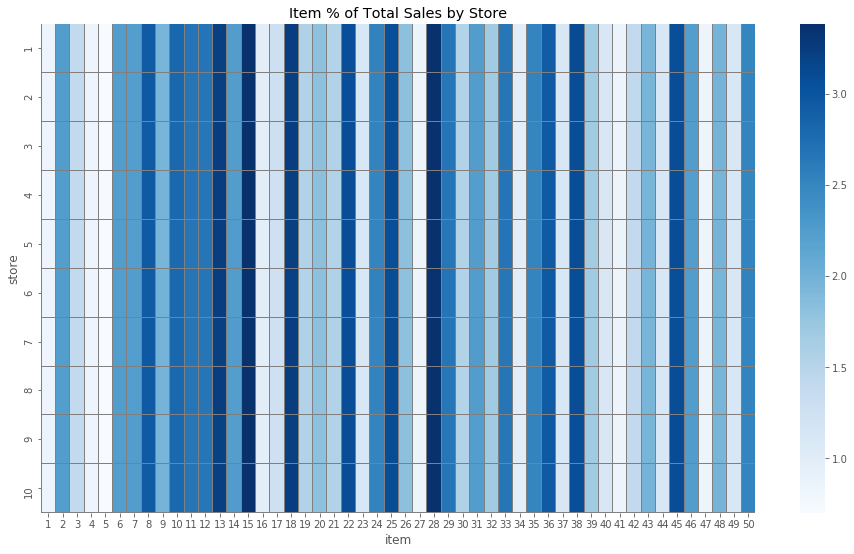

In [24]:
item_store = train.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

### Day of Week Variability

In [25]:
train['Day'] = train.index.weekday_name
train.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


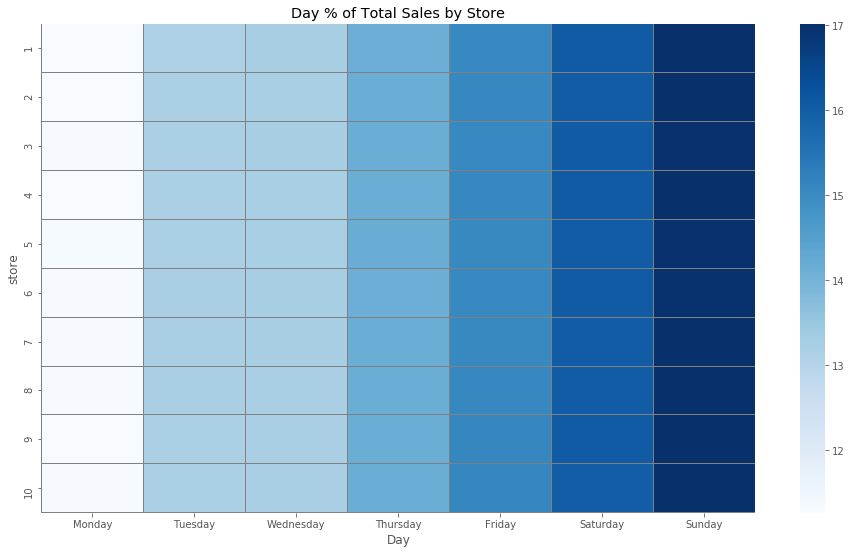

In [26]:
dow_store = train.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

In [27]:
dow_store

Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
store,,,,,,,
1,11.287669,13.172134,13.256409,14.131096,15.071590,16.065750,17.015351
2,11.287346,13.181881,13.225018,14.158544,15.100534,16.039272,17.007406
3,11.289600,13.192070,13.248260,14.146966,15.076454,16.055269,16.991381
4,11.282281,13.187385,13.221938,14.151887,15.099751,16.052722,17.004037
5,11.319063,13.196747,13.229520,14.166338,15.060881,16.041846,16.985604
6,11.295928,13.209471,13.261350,14.126698,15.082932,16.058600,16.965022
7,11.302530,13.205717,13.255566,14.155895,15.040110,16.042667,16.997514
8,11.289394,13.202232,13.216456,14.147440,15.091487,16.036832,17.016159
9,11.265434,13.196104,13.207465,14.155360,15.117044,16.063805,16.994789


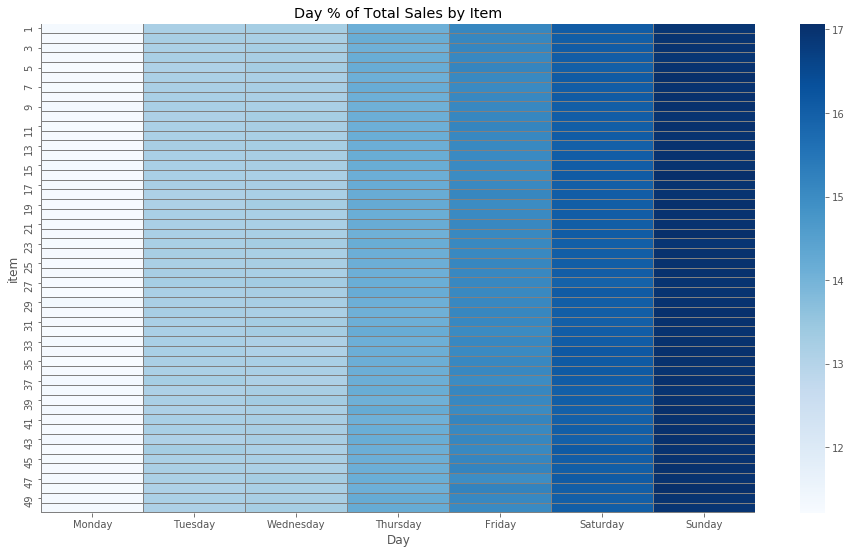

In [28]:
dow_item = train.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

In [29]:
dow = pd.DataFrame(train.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

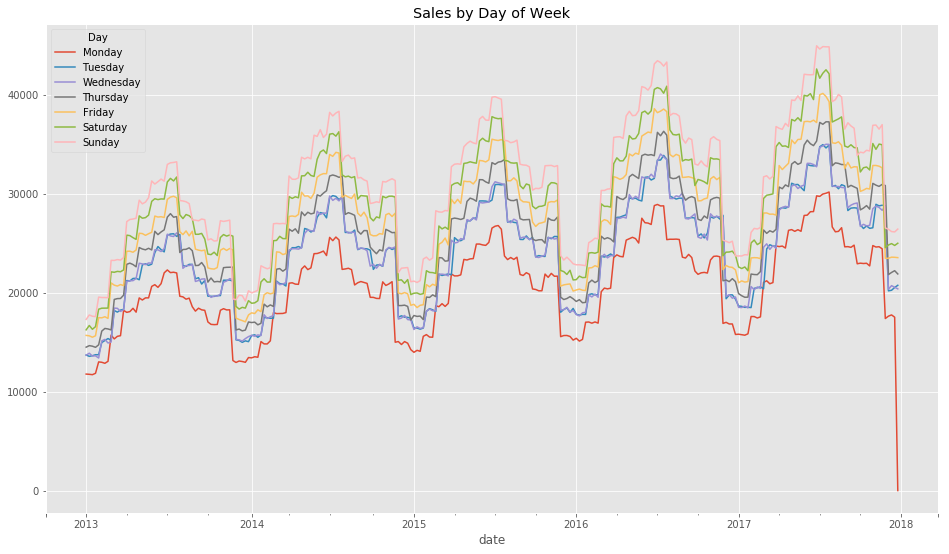

In [30]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

### Modeling The Data

In [31]:
#Transforming the sales figures to limit the impact of outliers during modeling

train['sales'] = np.log1p(train['sales'])

In [32]:
#Setting up the sales column in the test file

proph_results = test.reset_index()
proph_results['sales'] = 0
proph_results.head()

,date,id,store,item,sales
0,2018-01-01,0,1,1,0
1,2018-01-02,1,1,1,0
2,2018-01-03,2,1,1,0
3,2018-01-04,3,1,1,0
4,2018-01-05,4,1,1,0


In [33]:
#Setting Prophet Holiday Parameters

nfl_playoffs = ['2013-01-11','2013-01-12', '2013-01-19','2013-01-26','2013-02-02','2014-01-10', '2014-01-11',
            '2014-01-18', '2014-01-25','2014-02-01','2015-01-16','2015-01-17','2015-01-24','2015-01-31','2015-02-07', '2016-01-14',
            '2016-01-15', '2016-01-22','2016-01-29', '2016-02-05']
major_holidays = ['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25',
            '2017-01-01', '2017-12-25']

nfl_playoffs = pd.DataFrame({
    'holiday': 'nfl_playoffs',
    'ds': pd.to_datetime(nfl_playoffs),
    'lower_window': 0,
    'upper_window': 1,
})
major_holidays = pd.DataFrame({
    'holiday': 'major_holidays',
    'ds': pd.to_datetime(major_holidays),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat((nfl_playoffs, major_holidays))

In [35]:
#Algorithm for looping through the data and generating unique forecasts for each store and item combination.

for s in proph_results['store'].unique():
    for i in proph_results['item'].unique():
        proph_train = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        proph_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        
        m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            yearly_seasonality=4,  interval_width=0.95,
            changepoint_prior_scale=0.006, daily_seasonality=True)
        m.fit(proph_train[['ds', 'y']])
        future = m.make_future_dataframe(periods=len(test.index.unique()), include_history=False)
        fcst = m.predict(future)
        
        proph_results.loc[(proph_results['store'] == s) & (proph_results['item'] == i), 'sales'] = np.expm1(fcst['yhat']).values

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [36]:
proph_results.head(20)

,date,id,store,item,sales
0,2018-01-01,0,1,1,12.167199
1,2018-01-02,1,1,1,14.223279
2,2018-01-03,2,1,1,14.715463
3,2018-01-04,3,1,1,15.180512
4,2018-01-05,4,1,1,16.375830
5,2018-01-06,5,1,1,17.837253
6,2018-01-07,6,1,1,18.709562
7,2018-01-08,7,1,1,11.952826
8,2018-01-09,8,1,1,14.007302
9,2018-01-10,9,1,1,14.525544


In [37]:
proph_results.shape

(45000, 5)

In [43]:
proph_results.drop(['date', 'store', 'item'], axis=1, inplace=True)
proph_results.head()

,id,sales
0,0,12.167199
1,1,14.223279
2,2,14.715463
3,3,15.180512
4,4,16.375830


In [44]:
proph_results.to_csv('proph_results.csv', index=False)